# Yelp Review Analysis - GO TO ARIZONA!

**Team 3 members:  Yue Gong, Jingcheng Huang, David Hutchens, Youming Qiu, Yishuang Song, Minna Tang**

**Here's the content of this notebook:**
1. Data Overview  
    1.1 Preview of the Yelp business table  
    1.2 Preview of the Yelp review table  
    1.3 Preview of the Yelp user table  
    1.4 Preview of the Yelp checkin table  
2. Data Cleaning   
3. Users  
    3.1 What are the Top 10 regions with the highest count of Yelp users?  
    3.2 Are there reviewers who send primarily negative (or positive) reviews?  / Are the reviews valid?   
    3.3 Statistics of review counts and ratings for yelp users (user profile)   
    3.4 Who are the Top 10 most popular users on Yelp？
4. Business  
    4.1 Date range for business reviews in the sample  
    4.2 Top 5 store categories which received the most reviews   
    4.3 How many restaurants are there in total on Yelp in this sample?     
    4.4 What types of restaurants receive the best reviews?  
    4.5 Which city, state/region receives the highest rating for their local businesses?    
    4.6 What is the most popular five-star restaurant in this Yelp sample?   
    4.7 The number of checkins for "Little Miss BBQ" by day of the week      
    4.8 Which cities have the best restaurants?   
    4.9 Which category is the most popular in each city? 


## 1. Data Overview

The dataset that we chose is a subset of Yelp’s businesses, reviews, and user data. This dataset contains information about businesses across 11 metropolitan areas in 4 countries. There are approximately 5,200,000 customer reviews about information over 174,000 businesses.

The source of the data was derived from Kaggle. The dataset was: https://www.kaggle.com/yelp-dataset/yelp-dataset/version/6

**1.1 Preview of the Yelp business table**

In [9]:
%%bq query
SELECT *
FROM `team-3-ba770-b.yelp.business`
LIMIT 3

business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,lat_long
Gf4fPxATIn3goN5AMWe_ew,"""Peur Dépôt""",Ville-Marie,"""Place Des Vestiges Du Vieux Port, Entrée Quai Jacques Cartier""",Montréal,QC,,45.5055368451,-73.5523856833,2.0,5,1,Active Life;Amusement Parks,
KbEnEqk8MJQedWzQBps5Mg,"""Frankie & Benny's""",,"""South Gyle""",South Gyle,EDH,,55.9383107593,-3.3145679157,2.0,6,1,Restaurants;American (New),
TP0Eq8LJy8I1wOcWQBZ5ug,"""Lucky's truck""",Ville-Marie,"""""",Montréal,QC,,45.5086699,-73.5539925,2.0,5,1,Food;Food Trucks,


The following bubble chart shows the number of stores by region.  The bubbles are placed by latitude and longitude.

In [84]:
%%bq query -n stores_by_state

WITH temp1 AS(
SELECT DISTINCT state, COUNT(*) AS Number_of_stores
FROM `team-3-ba770-b.yelp.business`
GROUP BY state
),
temp2 AS(
SELECT DISTINCT state, AVG(latitude) AS lat, AVG(longitude) AS lon
FROM `team-3-ba770-b.yelp.business`
GROUP BY state
)

SELECT state, lon, lat, Number_of_stores
FROM temp1
LEFT JOIN temp2
USING(state)
WHERE lat>0 AND  Number_of_stores>2000

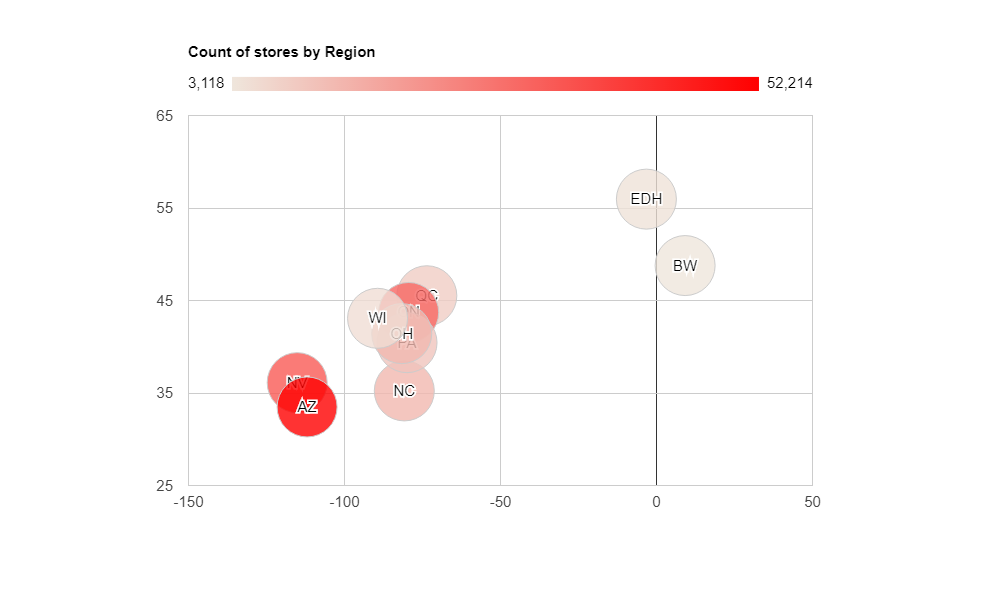

In [90]:
%%chart bubbles -d stores_by_state
title: Count of stores by Region
height: 600
width: 1000
colors: ['red']

The following pie chart shows the percentage of businesses in the dataset that are in business at the time the data was taken.

In [126]:
%%bq query -n open
SELECT CASE WHEN is_open=1 THEN 'open'
       ELSE 'not open' END AS open_state, count(*)
FROM `team-3-ba770-b.yelp.business`
group by is_open

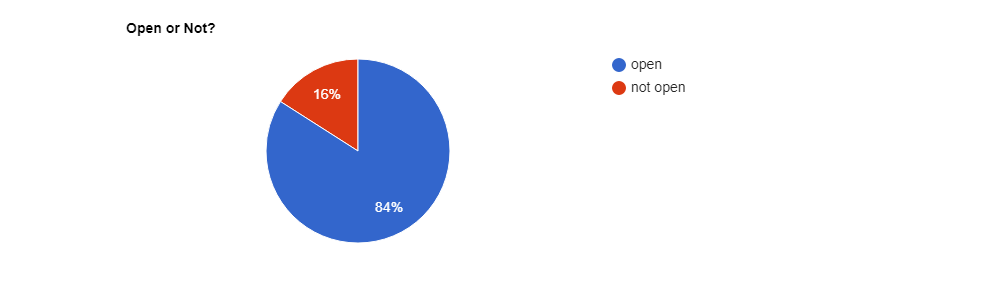

In [131]:
%%chart pie -d open
title: Open or Not?
height: 300
width: 1000

**1.2 Preview of the Yelp review table**

In [10]:
%%bq query
SELECT *
FROM `team-3-ba770-b.yelp.review`
LIMIT 3

review_id,user_id,business_id,stars,date,text,useful,funny,cool
3YpTbDtxrFy4agErrKRe3Q,tL2pS5UOmN6aAOi3Z-qFGg,i8hkzA5eiUXgbPjN8vK3rQ,4,2015-09-26,Recently had dinner here with my family and really enjoyed the experience. The staff was friendly and attentive. The food was great. Also I was surprised that gratuity is included in your bill. I found it a little pretentious that they automatically assume they deserve a tip.,0,0,1
H9CQDG-BUjcR3rvUJMDUsw,BytRWk8X1OelSgwwfXd8Aw,SfHE6qK6dT7wxX-Ow82tRg,5,2017-07-30,"Love the interior - it has this warm and lush atmosphere that is so comforting in the winter. The food is absolutely delicious and the service is so sweet and attentive. Great place for a quick drink, a cozy lunch or an intimate dinner.",0,0,0
zv94pT0McTuAVeQqA0jGMg,G5BqF32PyIQ5IvplDvpKnA,U--dPMMXYMaks6dV9AJnEw,3,2011-01-10,"Although I do enjoy the sanctity of the Apple Stores, this one is pretty good aside from one fact. It can become obnoxiously busy with people and become a sardine tin in a heartbeat. It especially has to do with kids coming in there to hop on Facebook and take pictures of themselves in the store. I know that doesn't really have anything to do with the store but that is where the staff comes in. The staff doesn't seemed to be concerned that I may be standing next to a product waiting for a kid to get off a Macbook Pro for example. They just head over, ask if I need any help, I respond by saying well I am trying to check out this (insert product here)... ""Oh alright well let us know if you have any questions"" and before I can respond with one they have disappeared. The store is relatively cleanly and organized but in addition to that, because of all these kids in there, 75% of the products are either broken or ""non-functional."" It is a great location but the staff needs to step it up when coming to customer-associate confrontation.",2,0,0


The following graph shows the number of reviews submitted each year.

In [150]:
%%bq query -n review
SELECT CAST(EXTRACT(year from date) AS STRING) AS year,COUNT(review_id) AS Number_of_reviews
FROM `team-3-ba770-b.yelp.review`
GROUP BY year
ORDER BY year

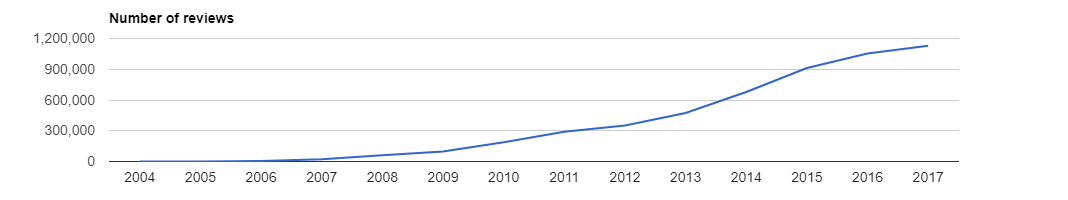

In [151]:
%%chart line -d review
title: Number of reviews
legend: none

**1.3 Preview of the Yelp user table**

In [1]:
%%bq query
SELECT *
FROM `team-3-ba770-b.yelp.user`
LIMIT 1

user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
faADnSAOEI1_7vi89eCHBw,Camron,2,2015-05-28,"7wRYC24Yq47y_nUF1eIKYA, OptdhTBHiEQgA70Y5-DcIw, cW-_WrNMaxnv3EmS03Rujw, cvpFV6afxsuFimAuo6qV_A, GOcno3adJTPCetIZs0-5cw, oA-Gmv7JGI1s6wARET2beg, Usc1hXmXSGt_PeFp_qALWg, 4FrmPXFGXkibwLPtpmR43g, GmGKaSbDB6F3ZlBt8ZodFQ, Uhln00lJ6IKbbETQ0-wxgg, lsSYT0BqPYe_jhCxXYrpmQ, v8_laNOV7Il6XC5Y22Aw4Q, xt_pfG1rFiCUkFXOIGIRDA, v1rVjzTDbE-0Y5IaXzJfTg, TqsGVuidb8febjHb3I-APQ, LwQCjit4nA0vFxb53sowuQ, L5R7J6MWmqzsrKytxkAXDg, zPRRjLm7UmF2BK3PmCOT0g, UTciA6nUV83xrOdlljcaKg, 6FJNTcLtEPvYwSuMNWUO1g, K5HKlZnQkM4f91ktWsIibg",0,0,0,0,None,5.0,0,0,0,0,0,0,0,0,0,0,0


**1.4 Preview of the Yelp checkin table**

In [12]:
%%bq query
SELECT *
FROM `team-3-ba770-b.yelp.checkin`
LIMIT 3

business_id,weekday,hour,checkins
uU8up3hGwW9qnzQD1HZsMQ,Fri,0:00,1
rXUZNVlpWMV5ORDDSguOEQ,Fri,0:00,3
0Myf2fOlXXNHgIuPZoOlsA,Fri,0:00,2


## 2. Data Cleaning

**Update to remove duplicate columns**

First, we started by cleaning and summarizing the dataset in order to get a general overview of it.  These are some examples of the cleaning statements that we ran, because some restaurants had identical categories, but were listed in a different order.


In [ ]:
%%bq query
UPDATE `team-3-ba770-b.yelp.business`
SET categories = REPLACE(categories,'Beauty & Spas;Nail Salons', 'Nail Salons;Beauty & Spas')
WHERE categories = 'Beauty & Spas;Nail Salons'

In [ ]:
%%bq query
UPDATE `team-3-ba770-b.yelp.business`
SET categories = REPLACE(categories,'Restaurants;Fast Food', 'Fast Food;Restaurants')
WHERE categories = 'Fast Food;Restaurants'


## 3. Users

**3.1 What are the Top 10 regions with the highest count of Yelp users?**

In [29]:
%%bq query -n Population_distribution
SELECT state, COUNT(u.user_id) AS Number_of_users
FROM `team-3-ba770-b.yelp.business` AS b 
JOIN `team-3-ba770-b.yelp.review`  AS r 
ON b.business_id = r.business_id 
JOIN `team-3-ba770-b.yelp.user` AS u 
ON u.user_id = r.user_id
GROUP BY state
ORDER BY Number_of_users DESC
LIMIT 10;

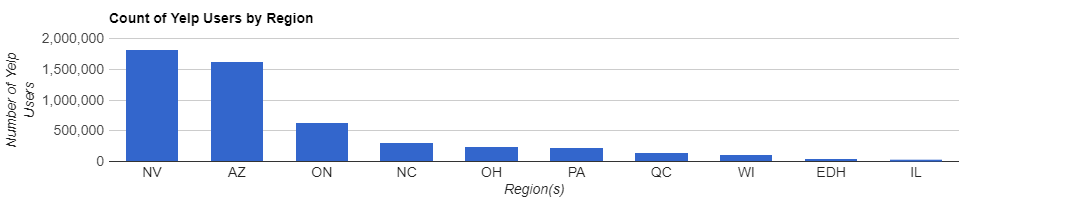

In [30]:
%%chart columns -d Population_distribution
title: Count of Yelp Users by Region
hAxis:
    title: Region(s)
vAxis:
  title: Number of Yelp Users
legend: none


From this query, we learned that Nevada and Arizona have the most Yelp users in this sample by far (at least 1.5 million).

**3.2 Are there reviewers who send primarily negative (or positive) reviews?  / Are the reviews valid?**

If a Yelp user makes primarily negative or positive reviews (for example 100 reviews all of 5 stars), then his or her reviews might not actually be valid, because they give the the same rating to almost everything.  The following query finds users who have made a relatively large number of reviews (at least 50) with either a very high (> 4.8 stars) or very low(<= 2 stars) average rating.

In [13]:
%%bq query 
SELECT DISTINCT user_id, review_count, average_stars,
CASE WHEN average_stars > 4.8 AND review_count > 50 THEN 'positive'
     WHEN average_stars <= 2 AND review_count > 50 THEN 'negative'
     END AS type_of_invalid_review
FROM `team-3-ba770-b.yelp.user`
WHERE (average_stars > 4.8 OR average_stars <= 2)
AND review_count > 50
ORDER BY review_count DESC, average_stars DESC

user_id,review_count,average_stars,type_of_invalid_review
9rgiTp7kcoJ0cOY6uQDn4g,684,4.99,positive
A-HI7Mcr_-SL60T3WvSjiQ,539,5.0,positive
j3BvyNHQbDrPPjcULV1vFg,419,4.82,positive
3_1mzpkxgJrLL1dQjv0OCQ,389,1.77,negative
IMVZIi7x3d3NIQH1T5MN-Q,367,4.83,positive
UHT_L45SKwAumCDo5ti1zA,352,4.87,positive
DCxqcPkac9RvBU19dsCCew,339,1.02,negative
NUGZkFjQJlqnbmoFR1fsaA,335,4.83,positive
hyJusnslNlSLflrThs-54w,318,4.83,positive
keBv05MsMFBd0Hu98vXThQ,306,4.85,positive


From this query, we can see that there are a considerable number of reviewers who give excessively positive or negative ratings.  This might be a reason to disregard their reviews as invalid.

**3.3 Statistics of review counts and ratings for yelp users (user profile)**

This query gives a basic statistical summary of the Yelp users in the sample.

In [32]:
%%bq query 
SELECT AVG(review_count) AS Avg_Review_Count, MIN(review_count) AS Min_Review_Count, MAX(review_count) AS Max_Review_Count, AVG(average_stars) AS Avg_Stars, MIN(average_stars) AS Min_Avg_Stars, MAX(average_stars) AS Max_Avg_Stars
FROM `team-3-ba770-b.yelp.user` 
WHERE review_count IS NOT NULL OR average_stars IS NOT NULL 


Avg_Review_Count,Min_Review_Count,Max_Review_Count,Avg_Stars,Min_Avg_Stars,Max_Avg_Stars
23.1171729131,0,11954,3.71084068321,1.0,5.0


The average Yelp user has submitted 23 reviews, and a single user has submitted as many as 11,594.  The average star rating given on Yelp is 3.71.

**3.4 Who are the Top 10 most popular users on Yelp？**

This query finds the most popular users by counting the number of friends the user has.

In [21]:
%%bq query 
SELECT user_id, name, array_length(split(friends, ',')) AS number_of_friends
FROM `team-3-ba770-b.yelp.user` 
WHERE friends != 'None'
GROUP BY user_id, name,number_of_friends
ORDER BY number_of_friends DESC
LIMIT 10


user_id,name,number_of_friends
qVc8ODYU5SZjKXVBgXdI7w,Walker,14995
iLjMdZi0Tm7DQxX1C1_2dg,Ruggy,12183
ZIOCmdFaMIF56FR-nWr_2A,Randy,8641
mV4lknblF-zOKSF8nlGqDA,Scott,8406
IU86PZPgTDCFwJEuAg2j7g,Danny,8402
F_5_UNX-wrAFCXuAkBZRDw,Rodney,8204
djxnI8Ux8ZYQJhiOQkrRhA,Abby,8094
c-Dja5bexzEWBufNsHfRrQ,Vince,8092
fgwI3rYHOv1ipfVfCSx7pg,Emi,7835
aKN3Fq2uaRJTwZRPlI5GcQ,Alex,7724


## 4. Business

**4.1 Date range for business reviews in the sample?**

This query shows the range of dates of reviews that each business received, and date_range shows the total number of days in this range.



In [34]:
%%bq query 
SELECT b.name, MIN(date) min_year, MAX(date) max_year, DATE_DIFF(MAX(date), MIN(date), day) date_range
FROM `team-3-ba770-b.yelp.review` r
JOIN `team-3-ba770-b.yelp.business` b
ON r.business_id = b.business_id
GROUP BY r.business_id, b.name
ORDER BY date_range DESC


name,min_year,max_year,date_range
"""Bellagio Hotel""",2004-10-19,2017-12-09,4799
"""Wyatt & Dad Shoe Repair Specialists""",2004-10-25,2017-12-08,4792
"""Papa Del's Pizza""",2004-10-19,2017-11-30,4790
"""Body English""",2004-10-19,2017-10-11,4740
"""Papa John's Pizza""",2004-10-19,2017-09-18,4717
"""Paris Las Vegas Hotel & Casino""",2005-01-24,2017-12-11,4704
"""Panda's Den""",2004-12-19,2017-11-04,4703
"""New York New York Hotel & Casino""",2005-01-24,2017-12-09,4702
"""Le Village Buffet""",2005-01-26,2017-12-09,4700
"""Pei Wei""",2005-02-02,2017-12-08,4692


**4.2 Top 5 store categories which received the most reviews**

In [35]:
%%bq query
SELECT categories, COUNT(review_count) AS reviews
FROM `team-3-ba770-b.yelp.business` 
GROUP BY categories
ORDER BY reviews DESC
LIMIT 5


categories,reviews
Pizza;Restaurants,1977
Coffee & Tea;Food,1907
Nail Salons;Beauty & Spas,1845
Mexican;Restaurants,1770
Chinese;Restaurants,1696


Four out of five of the results were food-related categories, so we decided to focus our following analysis on restaurants.

In [106]:
%%bq query -n 5categories
SELECT categories, COUNT(review_count) AS reviews
FROM `team-3-ba770-b.yelp.business` 
GROUP BY categories
ORDER BY reviews DESC
LIMIT 5

In [12]:
%%chart treemap -d 5categories
title: Top 5 store categories

**4.3 How many restaurants are there in total on Yelp in this sample?**


In [36]:
%%bq query
SELECT COUNT(categories) AS Number_of_Restaurants 
FROM `team-3-ba770-b.yelp.business` 
WHERE categories LIKE '%Restaurants%';

Number_of_Restaurants
54618


**4.4 What types of restaurants receive the best reviews?**

This query finds the best restaurants in terms of average stars and number of reviews, ordered respectively.  A restaurant with a large number of reviews and high average star rating is likely to be exceptional.

In [37]:
%%bq query
SELECT categories, stars, review_count
FROM `team-3-ba770-b.yelp.business`
WHERE review_count > 100 AND stars >= 4.5 AND categories LIKE '%Restaurants%'
ORDER BY stars DESC, review_count DESC
LIMIT 10


categories,stars,review_count
Restaurants;Barbeque,5.0,1463
Cafes;Tea Rooms;Food;Bubble Tea;Restaurants;Desserts,5.0,1165
Restaurants;Food;Poke;Hawaiian,5.0,494
Restaurants;Salad;Mediterranean;Sandwiches;Halal;Arabian,5.0,355
Food;Gelato;Restaurants;Ice Cream & Frozen Yogurt;American (New);Desserts,5.0,352
Breakfast & Brunch;Sandwiches;American (New);American (Traditional);Restaurants,5.0,336
Restaurants;Greek,5.0,327
Salad;American (Traditional);Restaurants;Fast Food;Sandwiches;Waffles;Hot Dogs,5.0,263
Bars;American (New);Karaoke;Nightlife;Asian Fusion;Cocktail Bars;Restaurants,5.0,240
Vegetarian;Hot Dogs;Restaurants;Latin American;Vegan;Colombian,5.0,233


From these results, we can see than barbeque restaurants receive a large number of excellent ratings, closely followed by cafes.

**4.5 Which city, state/region receives the highest rating for their local businesses?**

This query identifies the cities with the highest average ratings.

In [14]:
%%bq query 
SELECT city AS City, state AS Region, ROUND(AVG(stars),1) AS Avg_stars, SUM(review_count) AS tot_reviews
FROM `team-3-ba770-b.yelp.business`
GROUP BY city, state
HAVING state IS NOT NULL
AND SUM(review_count) > 100
ORDER BY Avg_stars DESC
LIMIT 5

City,Region,Avg_stars,tot_reviews
Sloan,NV,4.5,293
La Prairie,QC,4.4,103
Las Vegas,NV,4.4,355
Kirtland,OH,4.4,267
Scottdale,AZ,4.4,544


Sloan, NV is the highest-rated city, followed by Kirtland, OH.

**4.6 What is the most popular five-star restaurant in this Yelp sample?**

This query finds the restaurant with the highest number of reviews and also a five-star rating.

In [39]:
%%bq query
SELECT city, name,SUM(review_count) AS total_review,AVG(stars) AS avg_star 
FROM `team-3-ba770-b.yelp.business` 
GROUP BY city,name
HAVING total_review>100 AND avg_star=5
ORDER BY avg_star DESC,total_review DESC
LIMIT 1;


city,name,total_review,avg_star
Phoenix,"""Little Miss BBQ""",1463,5.0


**4.7 The number of checkins for "Little Miss BBQ" by day of the week**

In the previous query, we identified Little Miss BBQ as the most popular five-star restaurant.  This query finds the number of checkins for the restaurant.

In [16]:
%%bq query -n total_checkins_in_a_week
SELECT weekday, SUM(checkins) AS total_checkins
FROM `team-3-ba770-b.yelp.checkin` AS c JOIN `team-3-ba770-b.yelp.business` AS b 
ON b.business_id = c.business_id 
WHERE c.business_id = 'Xg5qEQiB-7L6kGJ5F4K3bQ' 
GROUP BY weekday
ORDER BY 
     CASE
          WHEN weekday = 'Sun' THEN 1
          WHEN weekday = 'Mon' THEN 2
          WHEN weekday = 'Tue' THEN 3
          WHEN weekday = 'Wed' THEN 4
          WHEN weekday = 'Thu' THEN 5
          WHEN weekday = 'Fri' THEN 6
          WHEN weekday = 'Sat' THEN 7
     END ASC;


The query results are then graphed below.

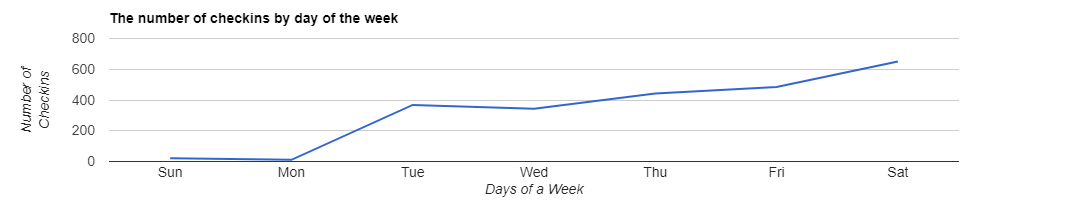

In [17]:
%%chart line -d total_checkins_in_a_week
title: The number of checkins by day of the week
legend: none
hAxis: 
    title: Days of a Week
vAxis:
    title: Number of Checkins

This graph shows that Little Miss BBQ is most poular on Saturday, and has no checkins on Sunday and Monday because it is closed.

**4.8 Which cities have the best restaurants?**

If you want more recommendations, here are the top cities that have the best restaurants.

In [18]:
%%bq query
SELECT city , COUNT(name) AS Number_of_best_resturants
FROM (SELECT city,name,SUM(review_count) AS total_review,AVG(stars) AS avg_star FROM `team-3-ba770-b.yelp.business` 
GROUP BY city,name
HAVING total_review>100 AND avg_star>4.5 
ORDER BY avg_star DESC, total_review DESC)
GROUP BY city
ORDER BY number_of_best_resturants DESC;


city,Number_of_best_resturants
Las Vegas,141
Phoenix,56
Scottsdale,35
Henderson,15
Gilbert,9
Tempe,9
Mesa,8
Charlotte,4
Toronto,4
Chandler,3


From this query, we can see that there are 141 popular restaurants in Las Vegas, followed by Phoneix and Scottsdale.

The query results are then graphed below.

In [19]:
%%bq query -n Best_restaurants
SELECT city , COUNT(name) AS Number_of_best_resturants
FROM (SELECT city,name,SUM(review_count) AS total_review,AVG(stars) AS avg_star FROM `team-3-ba770-b.yelp.business` 
GROUP BY city,name
HAVING total_review>100 AND avg_star>4.5 
ORDER BY avg_star DESC, total_review DESC)
GROUP BY city
ORDER BY number_of_best_resturants DESC;


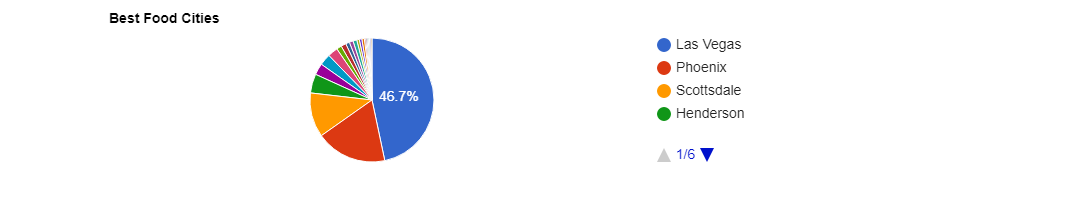

In [20]:
%%chart pie -d Best_restaurants
title: Best Food Cities
  

**4.9 Which category is the most popular in each city?**

We also think the number of checkins is a good indicator for popularity. Thus, we decided to use number of checkins to determine the most popular restaurant category in the top 3 popular cities, as shown from the previous query.

In [44]:
%%bq query 
WITH temp AS(
SELECT city, categories, SUM(checkins) AS Number_of_Checkins
FROM `team-3-ba770-b.yelp.business` AS b 
JOIN `team-3-ba770-b.yelp.checkin` AS c 
ON b.business_id = c.business_id
WHERE city IN( 'Las Vegas' , 'Phoenix' ,'Scottsdale') AND categories LIKE '%Restaurants%'
GROUP BY city, categories
ORDER BY Number_of_Checkins DESC
LIMIT 10)

SELECT *
FROM temp AS a
WHERE Number_of_Checkins = (SELECT MAX(Number_of_Checkins) FROM temp AS b WHERE a.city=b.city)


city,categories,Number_of_Checkins
Las Vegas,Mexican;Restaurants,65517
Phoenix,Mexican;Restaurants,46670
Scottsdale,Mexican;Restaurants,28457


Thus, we concluded that Mexican food is the most popular category in these three cities.